In [1]:
import os
os.chdir(os.getcwd()[:-6])

In [2]:
from float.data import DataLoader
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.feature_selection.fires import FIRES
from float.feature_selection.evaluation import FeatureSelectionEvaluator
from float.feature_selection.evaluation.measures import nogueira_stability
from float.pipeline import PrequentialPipeline
from float.visualization import plot, top_features_reference_bar
from sklearn.metrics import zero_one_loss
from skmultiflow.trees import HoeffdingTreeClassifier
import matplotlib.pyplot as plt

In [3]:
data_loader = DataLoader(None, f'float/data/datasets/spambase.csv', target_col=0)
ref_sample, _ = data_loader.stream.next_sample(50)
data_loader.stream.reset()
feature_selector = FIRES(n_total_features=data_loader.stream.n_features,
                           n_selected_features=20,
                           classes=data_loader.stream.target_values,
                           reset_after_drift=False,
                           baseline='expectation',
                           ref_sample=ref_sample)
fs_evaluator = FeatureSelectionEvaluator([nogueira_stability])
predictor = SkmultiflowClassifier(HoeffdingTreeClassifier(), data_loader.stream.target_values, reset_after_drift=True)
pred_evaluator = PredictionEvaluator([zero_one_loss], decay_rate=0.1, window_size=10)

prequential_pipeline = prequential_pipeline = PrequentialPipeline(data_loader=data_loader,
                                                                  feature_selector=feature_selector,
                                                                  feature_selection_evaluator=fs_evaluator,
                                                                  predictor=predictor,
                                                                  prediction_evaluator=pred_evaluator,
                                                                  max_n_samples=data_loader.stream.n_samples)
prequential_pipeline.run()

Pretrain predictor with 100 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation finished after 9.73060154914856s
Data Set float/data/datasets/spambase.csv
Processed 4601 instances in batches of 100
----------------------
Feature Selection (20/57 features):
| Model   |   Avg. Time | Avg. nogueira_stability                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

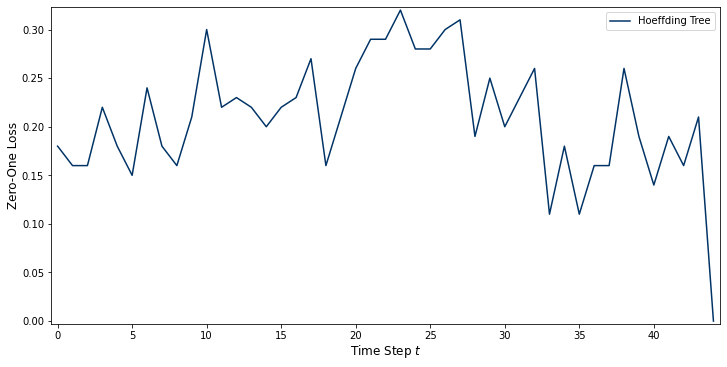

In [4]:
plot(measures=[pred_evaluator.result['zero_one_loss']['measures']],
     labels=['Hoeffding Tree'],
     measure_name='Zero-One Loss',
     measure_type='prediction',
     smooth_curve=[False])
plt.show()

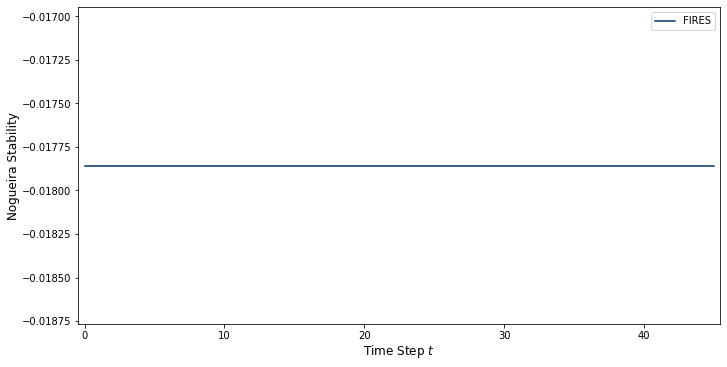

In [5]:
plot(measures=[fs_evaluator.result['nogueira_stability']['measures']],
     labels=['FIRES'],
     measure_name='Nogueira Stability',
     measure_type='feature_selection')
plt.show()

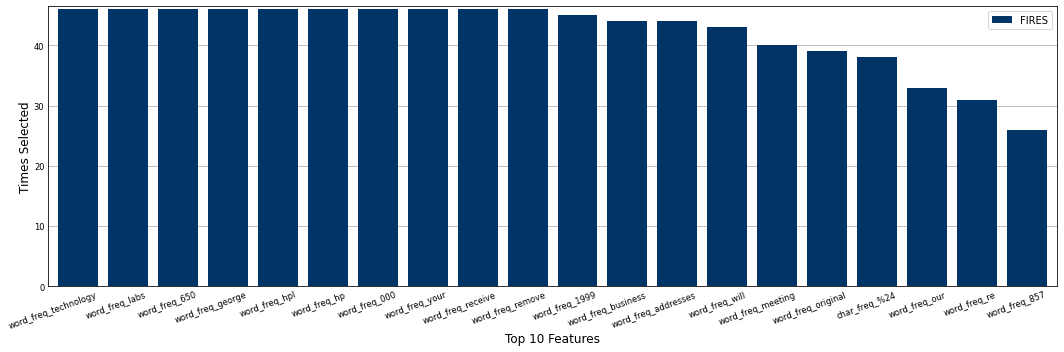

In [6]:
top_features_reference_bar(measures=[feature_selector.selected_features_history],
                           labels=['FIRES'],
                           measure_type='feature_selection',
                           feature_names=data_loader.stream.feature_names,
                           fig_size=(15, 5))
plt.show()